In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/bengaliai-cv19/test_image_data_0.parquet
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/class_map_corrected.csv
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train_multi_diacritics.csv
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/train.csv


In [2]:
train_df_ = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv')
test_df_ = pd.read_csv('/kaggle/input/bengaliai-cv19/test.csv')
class_map_df = pd.read_csv('/kaggle/input/bengaliai-cv19/class_map.csv')
sample_sub_df = pd.read_csv('/kaggle/input/bengaliai-cv19/sample_submission.csv')

In [3]:
train_df_.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [4]:
test_df_.head()

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [5]:
sample_sub_df.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0


In [6]:
class_map_df.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


In [7]:
print(f'Size of training data: {train_df_.shape}')
print(f'Size of test data: {test_df_.shape}')
print(f'Size of class map: {class_map_df.shape}')

Size of training data: (200840, 5)
Size of test data: (36, 3)
Size of class map: (186, 3)


## Exploratory Data Analysis
Exploratory data analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods.

In [8]:
HEIGHT = 236
WIDTH = 236

def get_n(df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map_df[class_map_df['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

def image_from_char(char):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    draw = ImageDraw.Draw(image)
    myfont = ImageFont.truetype('/kaggle/input/kalpurush-fonts/kalpurush-2.ttf', 120)
    w, h = draw.textsize(char, font=myfont)
    draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 3), char, font=myfont)

    return image

### Number of unique values

In [9]:
print(f'Number of unique grapheme roots: {train_df_["grapheme_root"].nunique()}')
print(f'Number of unique vowel diacritic: {train_df_["vowel_diacritic"].nunique()}')
print(f'Number of unique consonant diacritic: {train_df_["consonant_diacritic"].nunique()}')

Number of unique grapheme roots: 168
Number of unique vowel diacritic: 11
Number of unique consonant diacritic: 7


### Most used top 10 Grapheme Roots in training set

In [10]:
top_10_roots = get_n(train_df_, 'grapheme_root', 10)
top_10_roots

,index,component,count
72,72,দ,5736
64,64,ত,5596
13,13,ক,5420
107,107,ব,5321
23,23,গ,5149
96,96,প,4926
113,113,ভ,4395
147,147,স,4392
133,133,শ,4374
115,115,ম,4015


In [11]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)

In [12]:
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [13]:
IMG_SIZE=64
N_CHANNELS=1

Let's apply some image processing (credits: [this kernel](https://www.kaggle.com/shawon10/bangla-graphemes-image-processing-deep-cnn)) while resizing the images, which will center crop the region of interest from the original images.

In [14]:
HEIGHT = 137
WIDTH = 236

def resize(df, size=64):
    resized = {}
    data = 255 - df.iloc[:, :].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
    for i in tqdm(range(len(df))):
        #normalize each image by its max val
        #img = 255 - df.loc[df.index[i]].values.reshape(137,236)
        img = (data[i]*(255.0/data[i].max())).astype(np.uint8)
        img = crop_resize(img)
        resized[df.index[i]] = img.reshape(size*size)
    
    resized = pd.DataFrame(resized).T
    return resized

In [15]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=64, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

In [16]:
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

## Basic Model

In [17]:
inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "relu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model)

head_root = Dense(168, activation = 'softmax')(dense)
head_vowel = Dense(11, activation = 'softmax')(dense)
head_consonant = Dense(7, activation = 'softmax')(dense)

model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_2[0][0]                   
____________________________________________________________________________________________

Let's visualize the 3-tailed (3 output) CNN by plotting it.

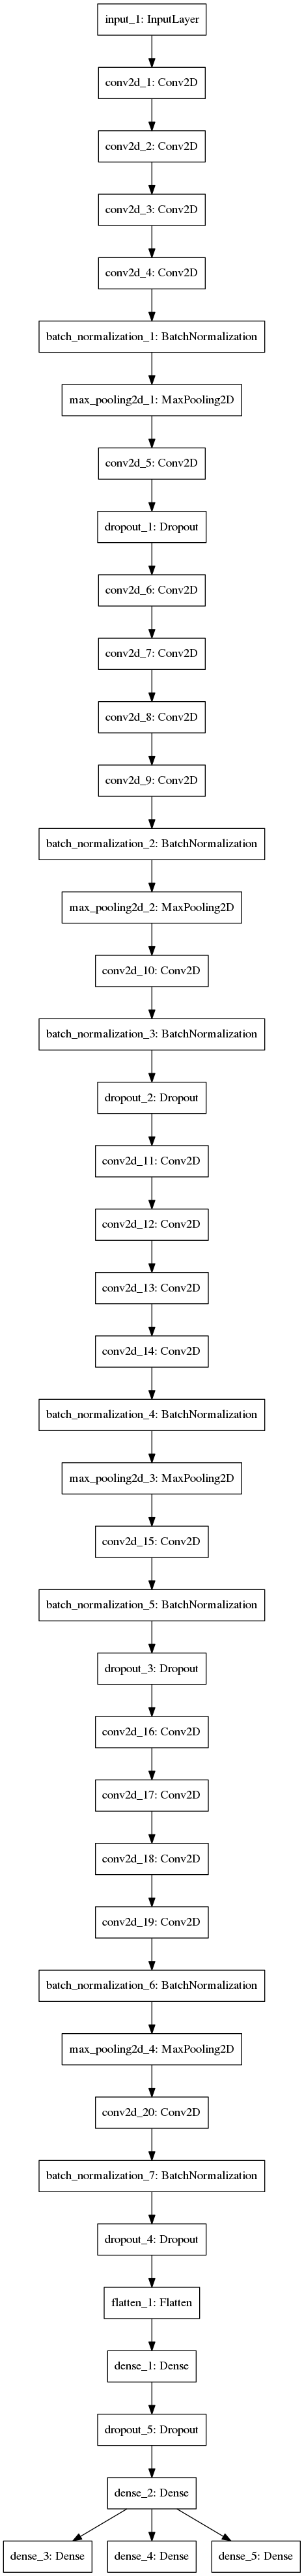

In [19]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_3_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_4_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_5_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [22]:
batch_size = 256
epochs = 30

In [23]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

### Training loop

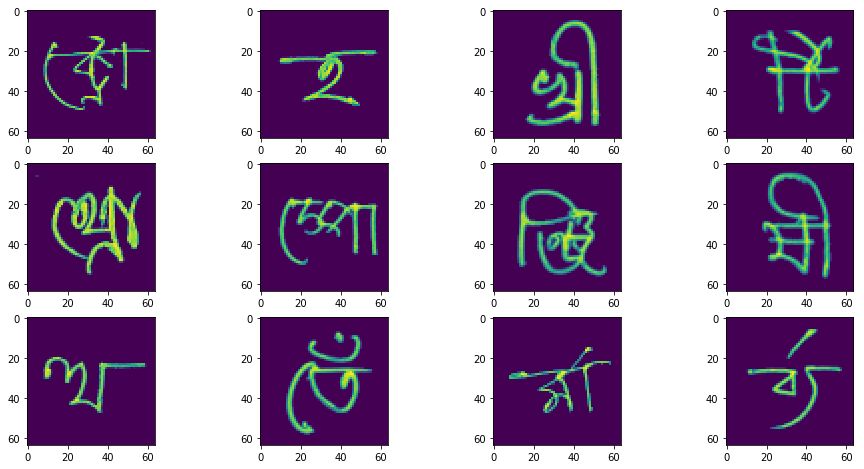


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
180/180 [==============================] - 45s 251ms/step - loss: 7.8416 - dense_3_loss: 4.7580 - dense_4_loss: 1.8420 - dense_5_loss: 1.2415 - dense_3_accuracy: 0.0270 - dense_4_accuracy: 0.3406 - dense_5_accuracy: 0.6193 - val_loss: 6.8056 - val_dense_3_loss: 4.6102 - val_dense_4_loss: 1.1150 - val_dense_5_loss: 1.0804 - val_dense_3_accuracy: 0.0373 - val_dense_4_accuracy: 0.5935 - val_dense_5_accuracy: 0.6114
Epoch 2/30
180/180 [==============================] - 36s 201ms/step - loss: 6.7229 - dense_3_loss: 4.5487 - dense_4_loss: 1.1269 - dense_5_loss: 1.0473 - dense_3_accuracy: 0.0376 - dense_4_accuracy: 0.6070 - dense_5_accuracy: 0.6423 - val_loss: 5.9092 - val_dense_3_loss: 4.3498 - val_dense_4_loss: 0.6950 - val_dense_5_loss: 0.8657 - val_dense_3_accuracy: 0.0413 - val_dense_4_accuracy: 0.7565 - val_dense_5_accuracy: 0.6948


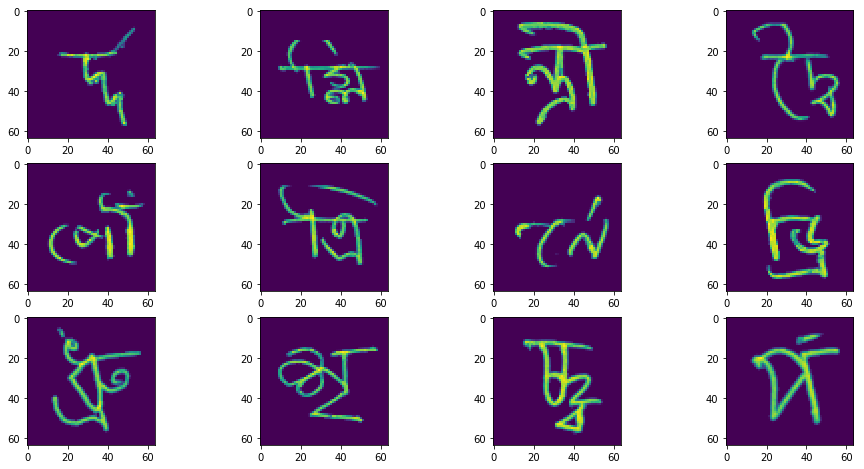


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
180/180 [==============================] - 36s 202ms/step - loss: 1.2059 - dense_3_loss: 0.7111 - dense_4_loss: 0.2853 - dense_5_loss: 0.2094 - dense_3_accuracy: 0.8097 - dense_4_accuracy: 0.9122 - dense_5_accuracy: 0.9363 - val_loss: 0.5530 - val_dense_3_loss: 0.3449 - val_dense_4_loss: 0.1130 - val_dense_5_loss: 0.0946 - val_dense_3_accuracy: 0.9024 - val_dense_4_accuracy: 0.9726 - val_dense_5_accuracy: 0.9749
Epoch 2/30
180/180 [==============================] - 35s 195ms/step - loss: 1.1261 - dense_3_loss: 0.6599 - dense_4_loss: 0.2659 - dense_5_loss: 0.2003 - dense_3_accuracy: 0.8200 - dense_4_accuracy: 0.9181 - dense_5_accuracy: 0.9405 - val_loss: 0.5374 - val_dense_3_loss: 0.3512 - val_dense_4_loss: 0.1004 - val_dense_5_loss: 0.0847 - val_dense_3_accuracy: 0.9002 - val_dense_4_accuracy: 0.9744 - val_dense_5_accuracy: 0.9761


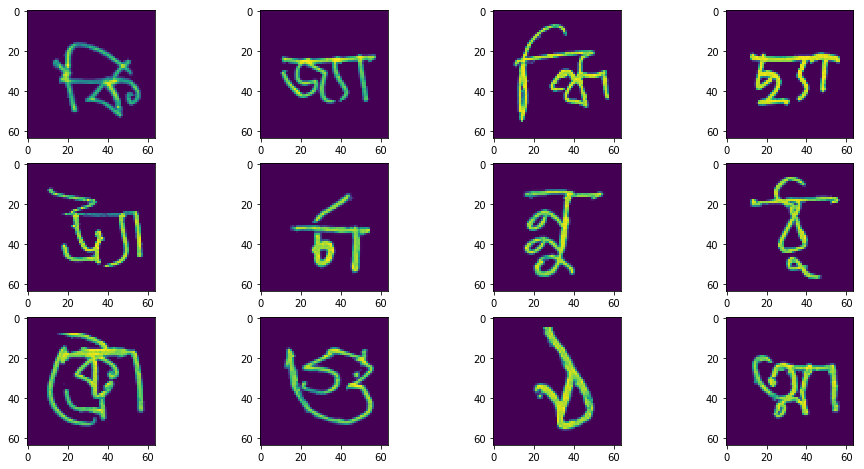


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
180/180 [==============================] - 35s 194ms/step - loss: 0.6109 - dense_3_loss: 0.3333 - dense_4_loss: 0.1605 - dense_5_loss: 0.1172 - dense_3_accuracy: 0.9093 - dense_4_accuracy: 0.9470 - dense_5_accuracy: 0.9641 - val_loss: 0.3434 - val_dense_3_loss: 0.2283 - val_dense_4_loss: 0.0682 - val_dense_5_loss: 0.0481 - val_dense_3_accuracy: 0.9417 - val_dense_4_accuracy: 0.9851 - val_dense_5_accuracy: 0.9861
Epoch 13/30
180/180 [==============================] - 35s 196ms/step - loss: 0.6144 - dense_3_loss: 0.3339 - dense_4_loss: 0.1625 - dense_5_loss: 0.1180 - dense_3_accuracy: 0.9083 - dense_4_accuracy: 0.9474 - dense_5_accuracy: 0.9641 - val_loss: 0.3397 - val_dense_3_loss: 0.2250 - val_dense_4_loss: 0.0680 - val_dense_5_loss: 0.0479 - val_dense_3_accuracy: 0.9432 - val_dense_4_accuracy: 0.9848 - val_dense_5_accuracy: 0.9863

In [24]:
histories = []
for i in range(4):
    train_df = pd.merge(pd.read_parquet(f'/kaggle/input/bengaliai-cv19/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
    for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]]).values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
            count += 1
    plt.show()
    
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255
    
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=12,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # Fit the model
    history = model.fit_generator(datagen.flow(x_train, {'dense_3': y_train_root, 'dense_4': y_train_vowel, 'dense_5': y_train_consonant}, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant])

    histories.append(history)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()

In [25]:
%matplotlib inline
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_3_loss'], label='train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_4_loss'], label='train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_5_loss'], label='train_consonant_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_loss'], label='val_train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_loss'], label='val_train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_5_loss'], label='val_train_consonant_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['dense_3_accuracy'], label='train_root_acc')
    plt.plot(np.arange(0, epoch), his.history['dense_4_accuracy'], label='train_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['dense_5_accuracy'], label='train_consonant_accuracy')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_accuracy'], label='val_root_acc')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_accuracy'], label='val_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['val_dense_5_accuracy'], label='val_consonant_accuracy')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()

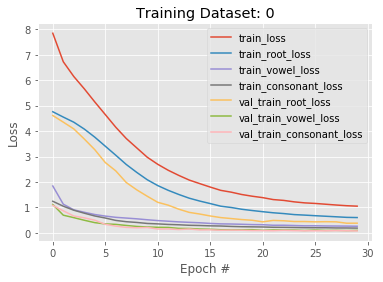

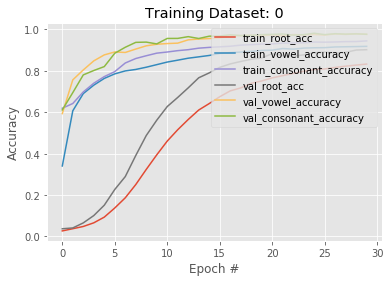

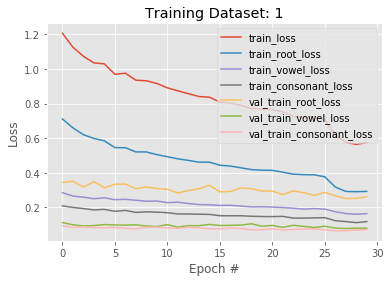

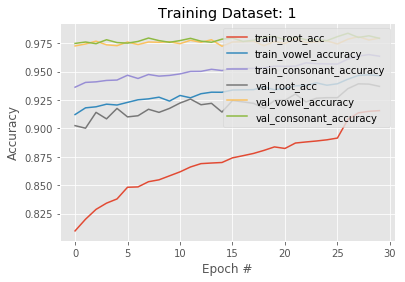

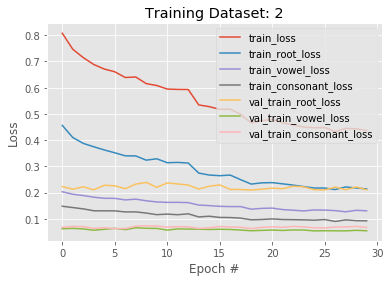

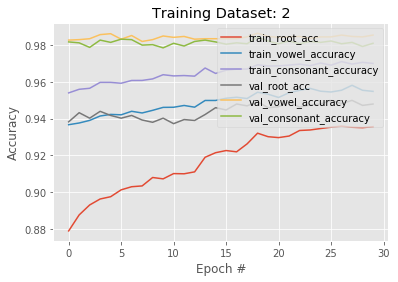

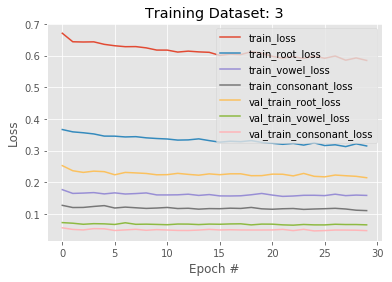

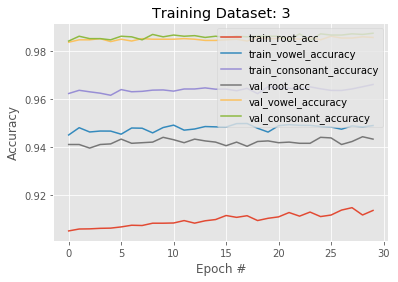

In [26]:
for dataset in range(4):
    plot_loss(histories[dataset], epochs, f'Training Dataset: {dataset}')
    plot_acc(histories[dataset], epochs, f'Training Dataset: {dataset}')

In [27]:
del histories
gc.collect()

27145

In [28]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [29]:
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder
for i in range(4):
    df_test_img = pd.read_parquet('/kaggle/input/bengaliai-cv19/test_image_data_{}.parquet'.format(i)) 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    preds = model.predict(X_test)

    for i, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax(preds[i], axis=1)

    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(preds_dict[comp][k])
    del df_test_img
    del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('submission.csv',index=False)
df_sample.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,93
